### Callin Switzer
###

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it
import sys
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.io
import glob
import itertools

# Neural net libs
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")

print(sys.version, "\n")
print("last run on " + str(datetime.now()))

Using TensorFlow backend.


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-09-25 14:30:31.524675


In [2]:
# data directory
dataDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Data"

# figure directory
figDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Figures" 
if not os.path.exists(figDir):
    os.makedirs(figDir)
    
# data output
dataOut = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\DataOut" ""
if not os.path.exists(dataOut):
    os.makedirs(dataOut)

In [3]:
# read in data
#"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Data\emglength_8_28.csv"

In [4]:
musLen = pd.read_csv(os.path.join(dataDir, "emglength_8_28.csv"))
musLen.drop(axis = 1, columns=musLen.columns[0], inplace=True)
print(musLen.shape)
#musLen["sec2"] = np.round(musLen.sec, decimals=4)
musLen.head(20)

(225009, 3)


,len,EMG,sec
0,-0.255774,0.058332,0.00000
1,-0.239091,0.058990,0.00004
2,-0.222407,0.059319,0.00008
3,-0.205724,0.059319,0.00012
4,-0.189040,0.058990,0.00016
5,-0.172357,0.058990,0.00020
6,-0.155673,0.058661,0.00024
7,-0.138990,0.060305,0.00028
8,-0.122306,0.058332,0.00032
9,-0.105623,0.056688,0.00036


In [5]:
comF = musLen

In [6]:
print(comF.shape)
comF.tail()

(225009, 3)


,len,EMG,sec
225004,-0.311007,0.023152,0.99984
225005,-0.313762,0.022494,0.99988
225006,-0.316516,0.023481,0.99992
225007,-0.319271,0.022165,0.99996
225008,-0.322025,0.021837,1.00000


In [7]:
sm = comF.iloc[:, ].copy()


In [8]:
# highpass filter
class SignalFilter:
    
    '''
    Does fft spectrum with accelerometer data
    
    '''
    def __init__(self, timesteps, sigl, cutoff = 200, order = 5, filtType = "high"):
        self.timesteps = timesteps
        self.sigl = sigl - np.mean(sigl)
        self.log_rate = len(self.timesteps)*(1/(np.round(np.max(self.timesteps), decimals = 1)))
        self.order = order
        self.filtType = filtType
        self.cutoff = cutoff
        nyq = 0.5 * self.log_rate
        normal_cutoff = self.cutoff / nyq
        self.b, self.a = signal.butter(self.order, normal_cutoff, btype=self.filtType, analog=False)


    def butter_highpass_filter(self, sigToFilter):
        newSig = np.concatenate([np.flip(sigToFilter[0:5000], axis = 0),
                                 sigToFilter, 
                                 np.flip(sigToFilter[-5000:len(sigToFilter)], axis = 0) ])
        self.newSig = newSig
        y = signal.filtfilt(self.b, self.a, newSig)
        self.filtered_sigl = y[5000:(sigToFilter.shape[0] + 5000)]
        
    
    def filterSignal(self):
        self.butter_highpass_filter(sigToFilter= self.sigl)
        self.filtered_sig_noMean = self.filtered_sigl - np.mean(self.filtered_sigl)
    
    
    def doubleIntegrate(self, sigToIntegrate):
        vel = np.cumsum(sigToIntegrate)/self.log_rate
        pos = np.cumsum(vel - np.mean(vel)) / self.log_rate
        self.pos_unfilt = pos - np.mean(pos)
        
        # highpass filter position
        self.butter_highpass_filter(sigToFilter= pos, cutoff = 100)
        self.pos = self.filtered_sigl - np.mean(self.filtered_sigl)
         
    
    def fft_fit(self, inputSignal):
        n =len(inputSignal) # length of the sigl
        k = np.arange(n, step = 1)
        T = n/self.log_rate
        frq = k/T # two sides frequency range
        frq = frq[range(int(n/2))] # one side frequency range

        # fft computing and normalization (note that *2 is so that it is scaled properly)
        Y = np.fft.fft(inputSignal)/n *2 
        Y = Y[range(int(n/2))]

        # calculate top frequency
        ind = np.argpartition(abs(Y), -4)[-4:]
        
        # Find highest point on the spectrum
        self.peakFrq = frq[ind[::-1]]
        self.pwr = (abs(Y)[ind[::-1]])
        
        self.dominant_freq = [x for (y,x) in sorted(zip(self.pwr,self.peakFrq), reverse = True)][0]
        self.max_amp = self.pwr[self.peakFrq == self.dominant_freq]
        self.Y = Y
        self.frq = frq
        self.fftSignal = inputSignal
        
        
        
    def plot_fft(self, title = ""):    
        plt.figure(figsize=(10,4))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

        # create subplot 1
        ax1 = plt.subplot(gs[0])
        ax1.plot(self.timesteps[0:len(self.fftSignal)],self.fftSignal, color = 'black', linewidth=0.5)
        ax1.set_title(title + " signal")
    
        # subplot 2
        ax2 = plt.subplot(gs[1])
        ax2.plot(self.frq, abs(self.Y), color = "black", linewidth=0.5)
        ax2.plot(self.dominant_freq, self.max_amp,'o', color = 'black', markersize = 5)
        ax2.set_xlim(-0, 1003)
        ax2.set_title(title + " FFT spectrum")
        plt.show()

In [9]:
sf = SignalFilter(timesteps = comF.sec, sigl = (comF.EMG), cutoff = 5000, filtType = "high")

In [10]:
sf.filterSignal()


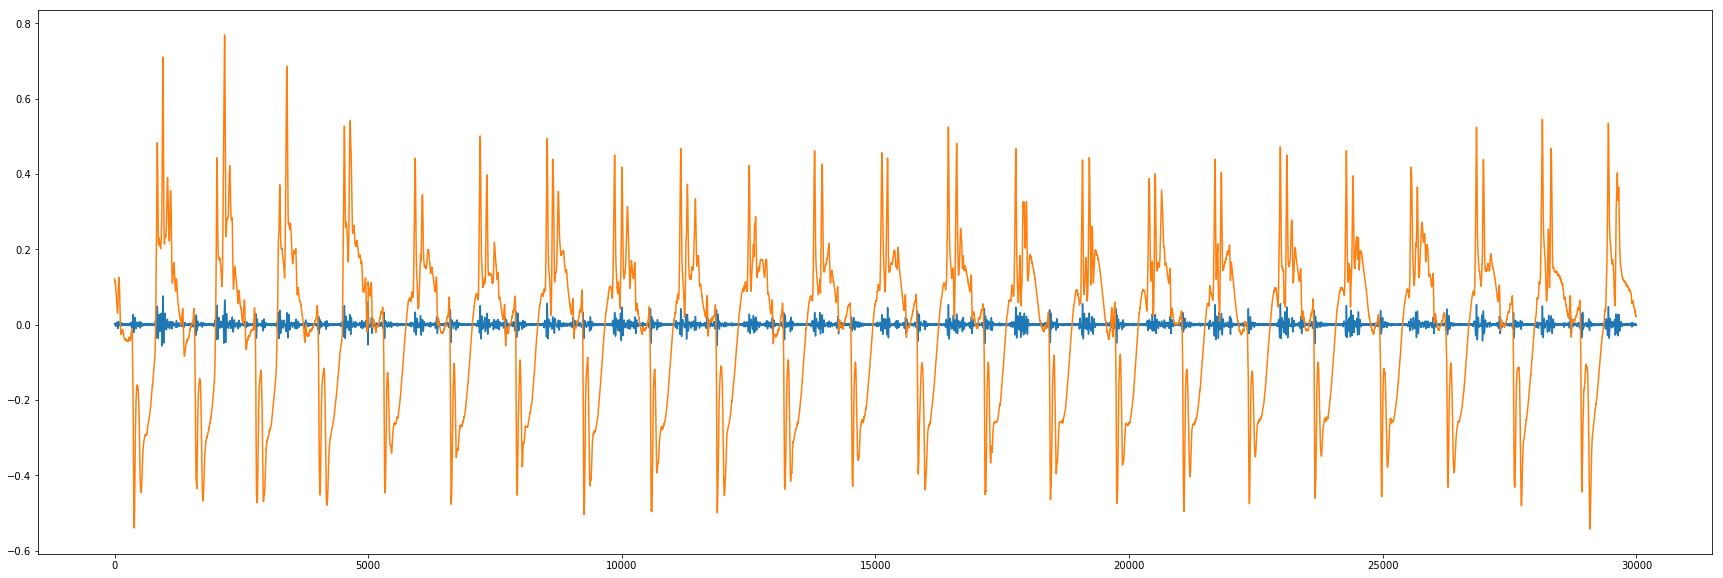

In [11]:
plt.figure(figsize=[30, 10])
plt.plot(sf.filtered_sig_noMean[-30000:])
plt.plot(np.arange(0, 30000), sf.sigl[-30000:])


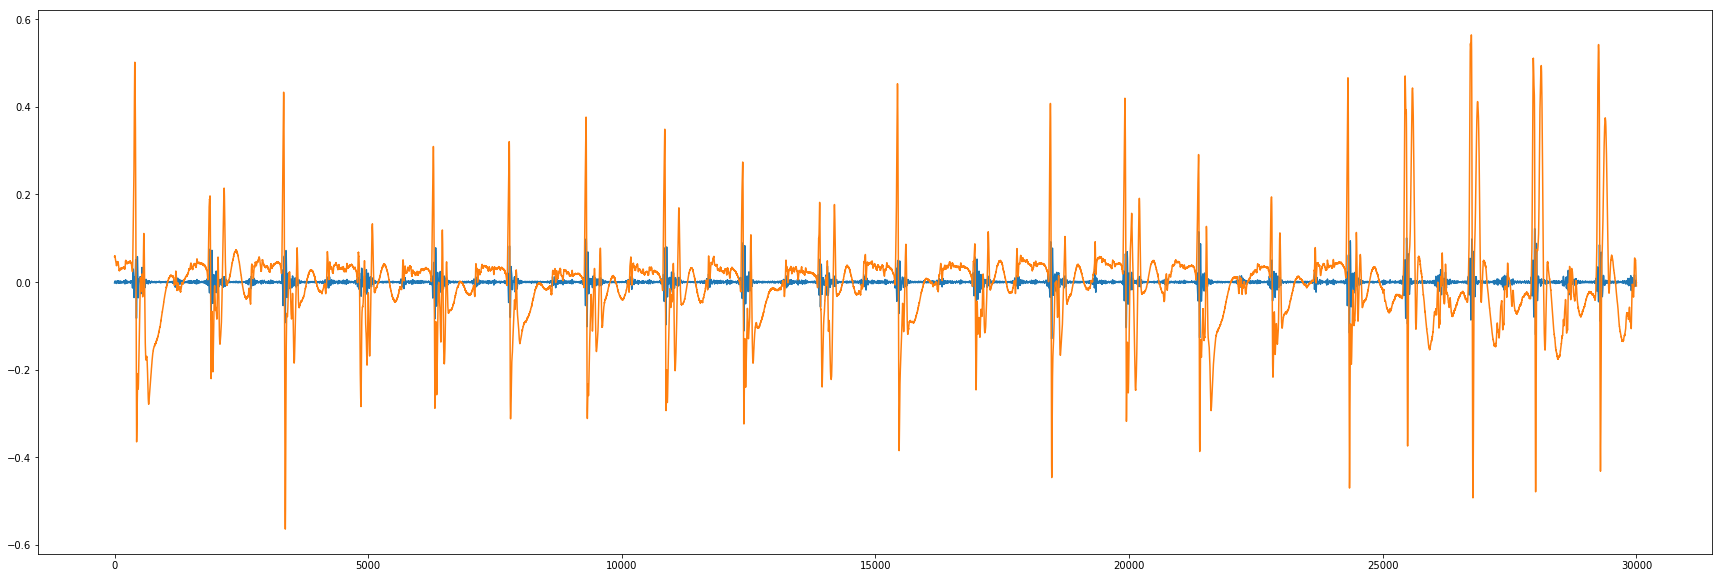

In [12]:
plt.figure(figsize=[30, 10])
plt.plot(sf.filtered_sig_noMean[:30000])
plt.plot(np.arange(0, 30000), sf.sigl[:30000])


In [13]:
comF["FilteredEMG"] = sf.filtered_sig_noMean

In [14]:
# try filtering b4 putting data through nnet refref

from scipy.signal import savgol_filter
yhat = savgol_filter(comF.len, 1001, 3) # window size 51, polynomial order 3
comF["filteredLen"] = yhat

In [15]:
from FFTUtils import * 

In [16]:
# plot FFT spectrum
spect = FFT(comF.filteredLen, log_rate = 25000.0)

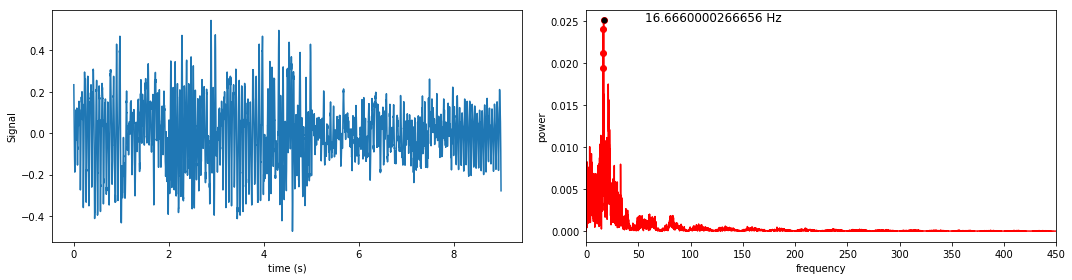

In [17]:
spect.FFT(fmin = 10, fmax = 45)
spect.plotFFT(fmin = 0, fmax =450)

In [18]:
# scale data


In [19]:
comF["ID"] = np.floor(comF.index / 25001).astype(int)

In [20]:
comF.groupby('ID').count()

,len,EMG,sec,FilteredEMG,filteredLen
ID,,,,,
0,25001,25001,25001,25001,25001
1,25001,25001,25001,25001,25001
2,25001,25001,25001,25001,25001
3,25001,25001,25001,25001,25001
4,25001,25001,25001,25001,25001
5,25001,25001,25001,25001,25001
6,25001,25001,25001,25001,25001
7,25001,25001,25001,25001,25001
8,25001,25001,25001,25001,25001


In [21]:
comF.head()

,len,EMG,sec,FilteredEMG,filteredLen,ID
0,-0.255774,0.058332,0.00000,-0.001792,0.234552,0
1,-0.239091,0.058990,0.00004,-0.001073,0.233481,0
2,-0.222407,0.059319,0.00008,-0.000622,0.232411,0
3,-0.205724,0.059319,0.00012,-0.000441,0.231340,0
4,-0.189040,0.058990,0.00016,-0.000530,0.230270,0


In [22]:
# split apply combine
grouped = comF.groupby("ID")
grouped

In [23]:
# drop last row for each group
c1 = comF[grouped.cumcount(ascending=False) > 100].copy()
grouped = c1.groupby("ID")
c2 = c1[grouped.cumcount(ascending=True) > 100].copy()
c2.shape

(223191, 6)

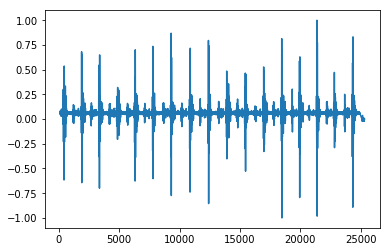

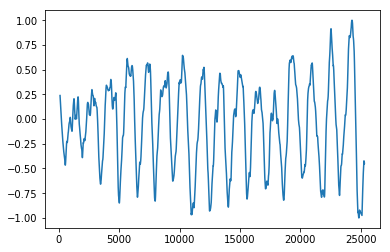

In [24]:
from sklearn.preprocessing import minmax_scale
c2['EMG_scaled'] = c2.groupby('ID').FilteredEMG.transform(lambda x: minmax_scale(x.astype(float), feature_range = (-1,1)))
c2['len_scaled'] = c2.groupby('ID').filteredLen.transform(lambda x: minmax_scale(x.astype(float), feature_range= (-1,1)))

plt.plot(c2.EMG_scaled[0:25001])
plt.show()
plt.plot(c2.len_scaled[0:25001])

___
# practice with real data
# tutorial here: https://www.youtube.com/watch?v=2np77NOdnwk
___

___
# Fully-connected nnet with windows
___

In [25]:
timesteps = np.arange(0, 1, 1/25000 )

freq = 25


Y = pd.DataFrame(c2.loc[:, "len_scaled"].values)
X =  pd.DataFrame(c2.loc[:, "EMG_scaled"].values)
Y.shape

(223191, 1)

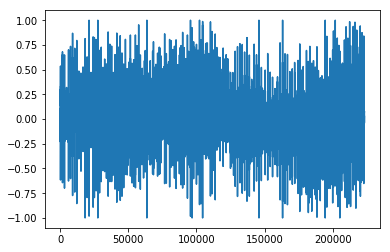

In [26]:
plt.plot(X.values)

In [27]:
len(X.values)

223191

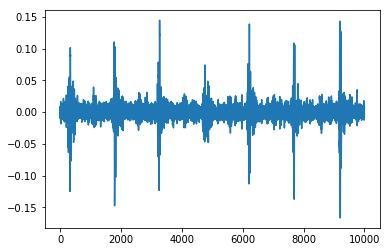

In [28]:
plt.plot(np.diff(X.values[0:10000], axis = 0 ))

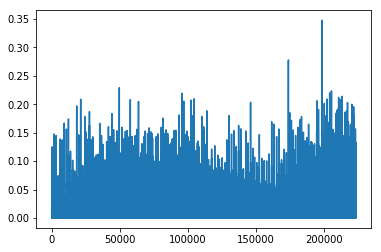

In [29]:
plt.plot(np.abs(np.diff(X.values, axis = 0 )))

In [30]:
X_sc = X.copy()
Y_sc = Y.copy()


In [31]:
split_index=  150000


from sklearn.preprocessing import MinMaxScaler

scX = MinMaxScaler(feature_range=(-0.5,0.5))
X_sc[:split_index] = scX.fit_transform(X_sc[:split_index])
X_sc[split_index:] = scX.transform(X_sc[split_index:])

scY = MinMaxScaler(feature_range=(-0.5,0.5))
Y_sc[:split_index] = scY.fit_transform(Y_sc[:split_index])
Y_sc[split_index:] = scY.transform(Y_sc[split_index:])


In [32]:
# add windows
for s in np.arange(1, 2000):
    X_sc['shift_{}'.format(s)] = X_sc[0].shift(s)
    X_sc['shift_{}'.format(s)] = X_sc[0].shift(s)


In [33]:

train_x = X_sc[:split_index].copy()
test_x = X_sc[split_index:].copy()

train_y = Y_sc[:split_index].copy()
test_y = Y_sc[split_index:].copy()

In [34]:
test_y.head()

,0
150000,-0.103011
150001,-0.103098
150002,-0.103161
150003,-0.103199
150004,-0.103212


In [35]:
train_y.tail()

,0
149995,-0.102224
149996,-0.102426
149997,-0.102607
149998,-0.102764
149999,-0.102899


In [36]:
train_x.head()

,0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_1990,shift_1991,shift_1992,shift_1993,shift_1994,shift_1995,shift_1996,shift_1997,shift_1998,shift_1999
0,0.031276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.030857,0.031276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.034338,0.030857,0.031276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.032325,0.034338,0.030857,0.031276,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.032898,0.032325,0.034338,0.030857,0.031276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
train_x.iloc[:, 0] = train_y.iloc[:,0]
#test_x.iloc[:, 0] = test_y.values
train_x.head(15)

,0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_1990,shift_1991,shift_1992,shift_1993,shift_1994,shift_1995,shift_1996,shift_1997,shift_1998,shift_1999
0,0.119140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.117988,0.031276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.116837,0.030857,0.031276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.115688,0.034338,0.030857,0.031276,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.114539,0.032325,0.034338,0.030857,0.031276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.113390,0.032898,0.032325,0.034338,0.030857,0.031276,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.112243,0.036088,0.032898,0.032325,0.034338,0.030857,0.031276,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.111096,0.040559,0.036088,0.032898,0.032325,0.034338,0.030857,0.031276,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.109951,0.035567,0.040559,0.036088,0.032898,0.032325,0.034338,0.030857,0.031276,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.108806,0.034584,0.035567,0.040559,0.036088,0.032898,0.032325,0.034338,0.030857,0.031276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
X_train = train_x.dropna().drop(0, axis=1)
y_train = train_x.dropna()[[0]]

X_test = test_x.dropna().drop(0, axis=1)
y_test = test_y.dropna()[[0]]

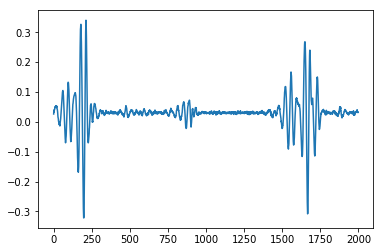

In [39]:
# plt.plot(np.array(X_train.iloc[0,:]))
plt.plot(np.array(X_train.iloc[0,:]))

In [40]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((148001, 1999), (73191, 1999), (148001, 1), (73191, 1))

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import BatchNormalization
import keras.backend as K

In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(40, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(40, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['mse'])
model.summary()


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta =0.001)

In [ ]:
hist = model.fit(X_train, y_train, epochs=10, validation_split= 0.1,
          batch_size=2**10, verbose=2,
          callbacks=[early_stop])

In [47]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()

In [ ]:
plot_model_history(hist, saveFig = False)

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize = [20,20])
plt.plot((X_test[:, 0]) + 1)
plt.plot((y_test))
plt.plot((y_pred))

In [ ]:
plt.plot(X_train[-25000:, 0])

In [ ]:
plt.figure(figsize=[20,20])
plt.plot(X_test[:, 0] + 1)
plt.plot(y_test)

In [ ]:
X_train.shape

In [ ]:
y_pred = model.predict(X_train)

plt.plot(X_train[:, 0] + 2)
plt.plot((y_train))
plt.plot((y_pred))

In [ ]:
X_train.shape

In [ ]:
plt.plot(X_train[:, 0] + 2)
plt.plot(y_train[:, 0])

# Use LSTM 

In [42]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import BatchNormalization
import keras.backend as K

In [43]:
X_train_t = X_train.reshape(X_train.shape[0], 1, -1)
X_test_t = X_test.reshape(X_test.shape[0], 1, -1)

In [77]:
K.clear_session()
model = Sequential()
model.add(LSTM(600, input_shape = (1, X_train_t.shape[2]), return_sequences=False, activation = "tanh"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(LSTM(6, return_sequences = True))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(LSTM(6, activation = "tanh"))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam", metrics =['mse'])

early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, min_delta =0.00001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=20, min_lr=0.00001)

In [108]:
hist = model.fit(X_train_t, y_train, epochs=5, validation_data = (X_test_t, y_test),
          batch_size=2**12, verbose=2,
          callbacks=[early_stop, reduce_lr])

Train on 148001 samples, validate on 73191 samples
Epoch 1/5
 - 9s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.6548 - val_mean_squared_error: 0.6548
Epoch 2/5
 - 9s - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.8177 - val_mean_squared_error: 0.8177
Epoch 3/5
 - 9s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.9041 - val_mean_squared_error: 0.9041
Epoch 4/5
 - 9s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.9996 - val_mean_squared_error: 0.9996
Epoch 5/5
 - 9s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.9415 - val_mean_squared_error: 0.9415


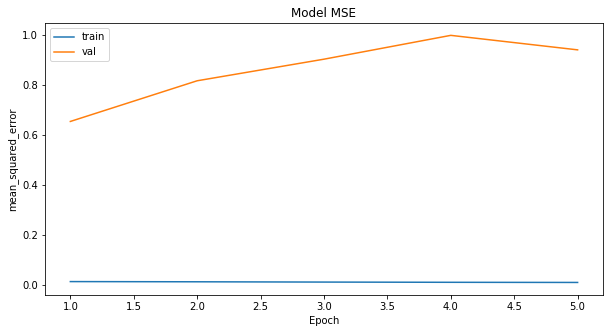

In [109]:
plot_model_history(hist, saveFig = False)

In [110]:
y_pred = model.predict(X_test_t)

In [111]:
X_test_t.shape
y_pred.shape

(73191, 1)

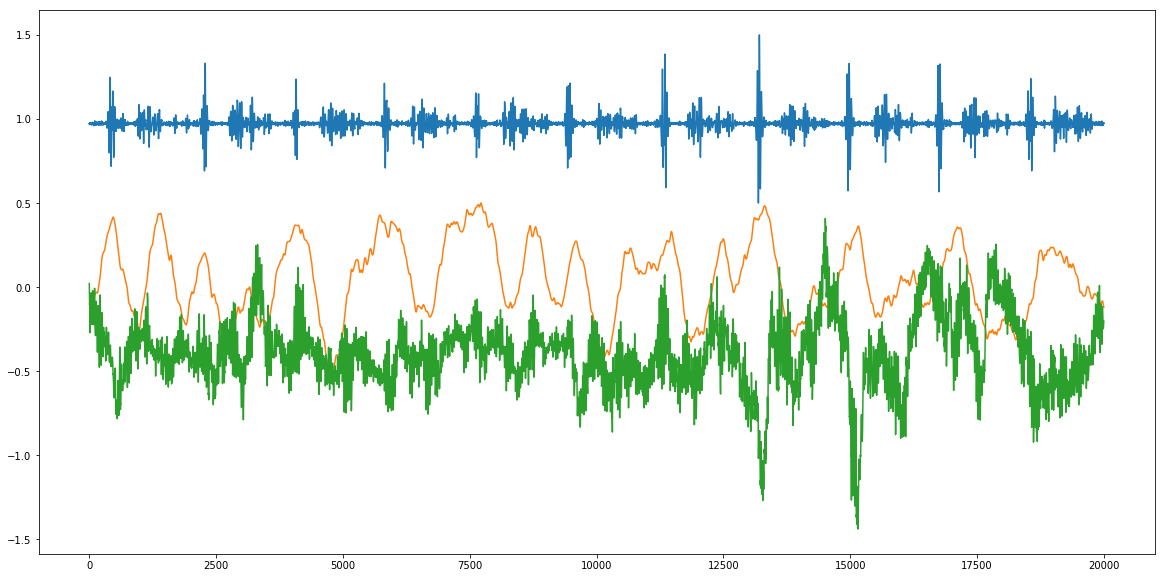

In [112]:
# predictions on test set
plt.figure(figsize = [20,10])
plt.plot((X_test[0:20000, 0]) + 1)
plt.plot((y_test[0:20000]))
plt.plot((y_pred[0:20000]))

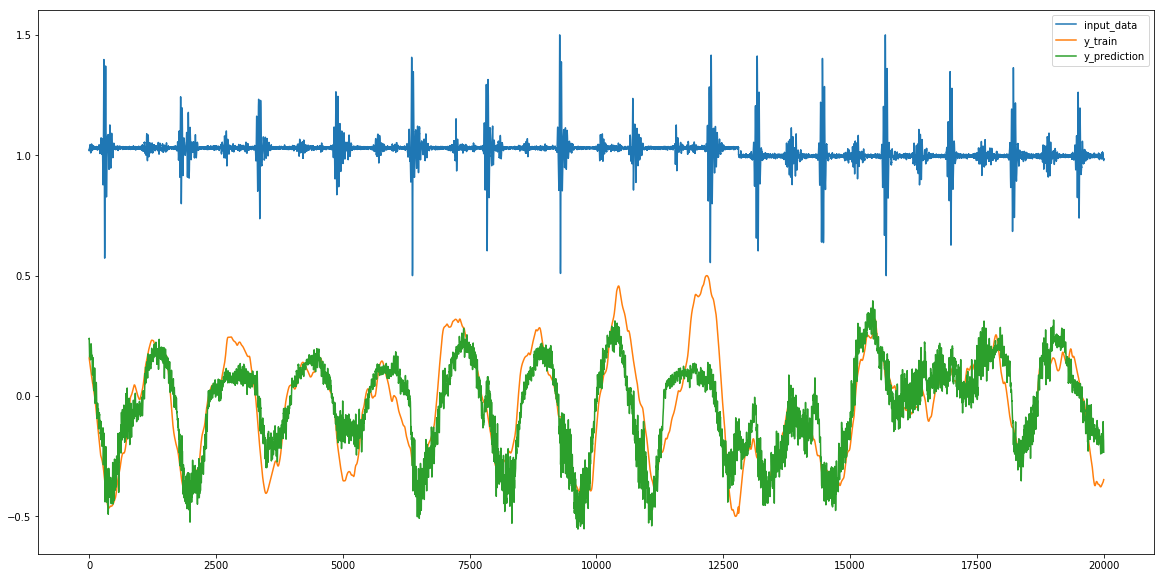

In [114]:
# predict on train set
indd = np.arange(10000, 30000)

y_pred = model.predict(X_train_t[indd])

plt.figure(figsize = [20,10])
plt.plot((X_train[indd, 0]) + 1, label = "input_data")
plt.plot((y_train[indd]), label = "y_train")
plt.plot((y_pred), label = "y_prediction")
plt.legend()

In [ ]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units = layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics = ['mse'])
    print("> Compilation Time : ", time.time() - start)
    return model

In [ ]:
model= build_model([1,50,100,1])
earlystop = EarlyStopping(monitor='val_mean_squared_error', min_delta=0.01, patience= 5, verbose=1, mode='auto')

In [ ]:
plt.plot(x_train[:, 499, 0])
plt.plot(y_train[:])

In [ ]:
model_info = model.fit(x_train, y_train, batch_size = 2**11, epochs=100, validation_split=0.05, callbacks = [earlystop])

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
plot_model_history(model_info)

In [ ]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [ ]:
predicted = predict_point_by_point(model, x_test)
predicted.shape

In [ ]:
plt.figure(figsize = (10, 4))
x_test.shape
plt.plot(x_test[:, 499, 0], label = "input")
#plt.plot(y_test[], label = "output")
plt.plot(y_test[-x_test.shape[0]:] + 2, label = "y")
plt.plot(minmax_scale(predicted, feature_range=(-1,1)) + 2, label = "prediction")
plt.legend()

In [ ]:
pp = model.predict(x_test)

In [ ]:
plt.plot(y_test)

In [ ]:
plt.plot(pp)

In [ ]:


plt.figure(figsize = (20, 8))
plt.plot(comF.EMG_scaled[-len(predicted):].reset_index(drop = True)+ 2, label = "EMG")
plt.plot(comF.len_scaled[-len(predicted):].reset_index(drop = True), label = "actual")
plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(comF.EMG_scaled[0:len(predicted)].reset_index(drop = True)+ 2, label = "EMG")
plt.plot(comF.len_scaled[0:len(predicted)].reset_index(drop = True), label = "actual")
#plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
x_test.shape

In [ ]:
predicted = predict_point_by_point(model, x_train[0:25000,:,:])
predicted.shape

In [ ]:

plt.figure(figsize = (20, 8))
plt.plot(x_train[0:25000, 999, 0])
plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
comF.EMG_scaled[0:len(predicted)].reset_index(drop = True)

In [ ]:
def reshape_dataTestONLY(sequence, ysequence, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(sequence) - sequence_length):
        result.append(sequence[index: index + sequence_length])
    result = np.array(result)
    
    result2 = []
    for index in range(len(ysequence) - sequence_length):
        result2.append(ysequence[index: index + sequence_length])
    result2 = np.array(result2)

    # shuffle windows
    #shuffInt = np.random.choice(np.arange(0, train.shape[1]), replace=False, size=train.shape[1])
#     train = train[:, shuffInt]
#     train2 = train2[:, shuffInt]
    #np.random.shuffle(train)

    x_test = result[:, :-1]
    y_test = result2[:, -1]

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    
    
    return [x_test, y_test]

In [ ]:
timesteps = np.arange(0, 0.5, 1/25000 )

freq = 25

trainY1 = np.sin(2*np.pi*timesteps* freq) + np.random.normal(size=len(timesteps))*0.1
trainX1 =  np.cos(2*np.pi*timesteps * freq) * ((np.cos(2*np.pi*timesteps*freq)) > 0.99)*1 + np.random.normal(size=len(timesteps))*0.1
trainY1.shape

In [ ]:
plt.plot(minmax_scale(trainX1[0:12500], (-1,1)))
x_test2, _ = reshape_dataTestONLY(minmax_scale(trainX1[0:12500], (-1,1)), trainY1, 1000)
plt.show()
plt.plot(x_test2[:, 999, 0])

In [ ]:
predicted = predict_point_by_point(model, x_test2)
predicted.shape

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(x_test2[:, 999, 0], label = 'made-up EMG signal')
plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
propBreak = 0.9
windowLen = 200

backCt = int(len(trainX) - propBreak * len(trainX) + propBreak * windowLen)
print(backCt)

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(trainY_scaled[-(backCt + 1):] + 2, label = "input data")
plt.plot(trainX_scaled[-(backCt-windowLen +1):], label = "data we're trying to predict")

plt.plot(x_test[:,0,0] + 2, label = "input data")
plt.plot(y_test[:], label = "ytest")
#plt.plot(yhat[-81:] -1, label = "smoothed")
plt.ylim([-2, 4])
plt.plot(predicted, label = 'predicted_LSTM')
plt.legend()
#plt.plot(y_test)
#plt.savefig(os.path.join(figDir, "LSTM_MadeUpData.png"), dpi = 500)


In [ ]:
plt.figure(figsize = (10,4))
plt.plot(trainY_scaled[-(backCt - windowLen +  1):] + 2, label = "input data")
plt.plot(trainX_scaled[-(backCt-windowLen +1):], label = "data we're trying to predict")

plt.plot(x_test[:,windowLen-1,0] + 2, label = "input data")
plt.plot(y_test[:], label = "ytest")

plt.ylim([-2, 4])
plt.plot(predicted, label = 'predicted_LSTM')
plt.legend()


In [ ]:
plt.plot(trainY_scaled[-(backCt + 1):] + 2, label = "input data")
plt.plot(trainX_scaled[(-backCt):], label = "data we're trying to predict")

In [ ]:
results = reshape_data(trainX, 50)

In [ ]:
np.random.shuffle(results)
results.shape

shuffInt = np.random.choice(np.arange(0, results.shape[1]), replace=False, size=results.shape[1])
results[:, shuffInt]

In [ ]:
shuffInt = np.random.choice(np.arange(0, result.shape[0]), replace=False, size=result.shape[0])
    train = train[:, shuffInt]